# Complex Examples With Duet

This notebook contains more complex examples of using Duet to run queries on a dataset.

Contents:
- [Laplace Examples:](#laplace)
    - [Auto Average](#auto-average)
    - [Report Noisy Max](#noisy-max)
- [Sparse Vector Technique:](#svt)
    - [Range Query](#range)
    - [Bounded Above](#bounded-above)
- [Graphical:](#graph)
    - [Cummulative Distribution](#cdf)
    - [Histogram](#histogram)
- [Applications:](#applications)
    - [Hierarchical Queryies](#census)
    - [Auto stats](#stats)
    

### Setup

In [1]:
import duet
from duet import pandas as pd
from duet import numpy as np
import matplotlib.pyplot as plt

adult_data = pd.read_csv("adult_with_pii.csv")

### Auto Average using Laplace <a name="auto-average"></a>

In [2]:
def dp_auto_avg(df, col, bs, clip_lower, epsilon):
    """ Returns a differentially private answer to a counting query 
    using the laplace function with privacy cost epsilon
    
    Args:
    df -- dataframe 
    col -- column in the dataframe to count
    clip_lower -- lower clipping parameter
    epsilon -- privacy cost
    """
    
    n = len(bs)
    epsilon_i = epsilon / (n + 1)
    
    noisy_count = duet.laplace(df[col].shape[0], ε=epsilon_i)
    last_val = 0
    for b in bs:
        noisy_sum = duet.laplace(df[col].clip(clip_lower, b).sum(), ε=epsilon_i)
        noisy_avg = noisy_sum / noisy_count
        
        if abs(noisy_avg - last_val) < 0.01 * b:
            return last_val
        else:
            last_val = noisy_avg

epsilon = 0.01
bs = [10**n for n in range(10)]
with duet.EDOdometer() as odo:
    print('Query result:', dp_auto_avg(adult_data, 'Age', bs, 0, epsilon))
    print('Privacy cost:', odo)

Query result: -870444.4504308212
Privacy cost: ([DataSource(adult_with_pii.csv): (0.00909090909090909, 0)])


### Report Noisy Max using Laplace <a name="noisy-max"></a>

In [3]:
def report_noisy_max(df, col, R, epsilon):
    """ Returns a differentially private answer to a max query
    using the laplace function with privacy cost R * epsilon
    
    Args:
    df -- dataframe 
    col -- column in the dataframe to count
    R -- different options to find max of
    epsilon -- privacy cost
    """
    
    
    def score(df, col, option):
        """ Helper method to return the size of a category
        
        Args:
        df -- dataframe
        col -- column in the dataframe to count
        option -- value in the dataframe to count
        """    
        return df[df[col] == option].shape[0]
    
    
    scores = [score(df, col, r) for r in R]
    noisy_scores = [duet.laplace(score, ε=epsilon) for score in scores]
    max_score = max(noisy_scores)
    max_score_idx = noisy_scores.index(max_score)
    
    return R[max_score_idx]


# List of all options in 'Marital Status' column
options = ['Never-married', 'Married-civ-spouse', 'Divorced',
           'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
           'Widowed']

epsilon = 0.01
with duet.EDOdometer() as odo:
    print('Query result:', report_noisy_max(adult_data, 'Marital Status', options, epsilon))
    print('Privacy cost:', odo)

Query result: Married-civ-spouse
Privacy cost: ([DataSource(adult_with_pii.csv): (0.07, 0)])


## Sparse Vector Technique

### Range Query using Sparse Vector Technique <a name="range"></a>

In [4]:
def sparse(queries, df, c, T, epsilon):
    """ Duet implementation of the sparse algorithm
    from Dwork and Roth
    """
    idxs = []
    pos = 0
    epsilon_i = epsilon / c
    
    while pos < len(queries) and len(idxs) < c:
        next_idx = duet.above_threshold(queries[pos:], df, T, epsilon_i)
        
        if next_idx == -1:
            return idxs
        
        pos = next_idx+pos
        idxs.append(pos)
        pos = pos + 1

    return idxs

def range_query(df, col, lower, upper):
    df1 = df[df[col] > lower]
    return (df1[df1[col] < upper]).shape[0]

def create_random_range_query(col):
    lower = np.random.randint(30, 50)
    upper = np.random.randint(lower, 70)
    return lambda df: range_query(df, col, lower, upper)

def range_query_svt(df, queries, c, T, epsilon):
    """ Returns a differentially private answer list of range queries
    using the sparse vector technique
    
    Args:
    df -- dataframe 
    queries -- list of values to check bounded above
    c -- number of answers returned
    T -- above_threshold value
    epsilon -- privacy cost
    """
    sparse_epsilon = epsilon / 2
    indices = sparse(queries, df, c, T, sparse_epsilon)
    
    laplace_epsilon = epsilon / (2*c)
    results = [duet.laplace(queries[i](df), epsilon=laplace_epsilon) for i in indices]
    return results

range_queries = [create_random_range_query('Age') for i in range(10)]
with duet.EDOdometer() as odo:
    print('Query result:', range_query_svt(adult_data, range_queries, 5, 10000, 1))
    print('Privacy cost:', odo)

Query result: [11591.571456926284, 18260.063298302823, 11283.16172000147, 14986.808424502125, 10285.107079256964]
Privacy cost: ([DataSource(adult_with_pii.csv): (0.9999999999999999, 0)])


### Bounded Above Query <a name="bounded-above"></a>

In [5]:
def value_query(df, col, i):
    return  lambda df: (df[col].value_counts()[i])

def bounded_all_above_x(df, queries, x, c, epsilon):
    """ Returns a differentially private answer to a bounded above query
    using the sparse vector technique
    
    Args:
    df -- dataframe 
    queries -- list of values to check bounded above
    x --  threshold for bounded above
    c -- number of answers returned
    epsilon -- privacy cost
    """
    answers = []
    pos = 0
    T = x
    epsilon_i = epsilon / (c*2)
    
    while len(answers) < c:
        answer_idx = duet.above_threshold(queries[pos:], adult_data, T, epsilon_i)
        if answer_idx == None:
            break
        pos = pos + answer_idx
        answers.append(duet.laplace(queries[pos:][0](df), epsilon=epsilon_i))
        pos = pos + 1
        
    return answers

queries = [value_query(adult_data, 'Marital Status', i) for i in range(7)]
x = 500
c = 4
epsilon = 10
with duet.EDOdometer() as odo:
    print('Query result:', bounded_all_above_x(adult_data, queries, x, c, epsilon))
    print('Privacy cost:', odo)

Query result: [14975.921790337685, 10682.857890582498, 4442.056086286525, 1025.3125523491387]
Privacy cost: ([DataSource(adult_with_pii.csv): (10.0, 0)])


## Graphical Examples  <a name="graph"></a>

### Cumulative Distribution Function <a name="cdf"></a>

Privacy cost: (5, 0.06100000000000005)


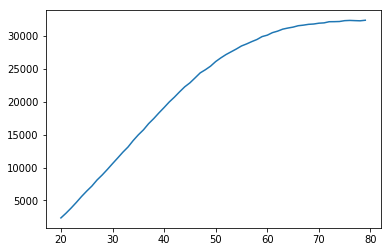

In [7]:
def calculate_cdf(df, col, val_lower, val_upper, alpha, epsilon):
    """ Returns a differentially private cumulative density 
    using alpha-epsilon Renyi differential privacy 
    
    Args:
    df -- dataframe 
    col -- column in the dataframe to count
    val_lower -- lower value to start from
    val_upper -- upper value to end at
    alpha -- alpha value for RDP
    epsilon -- epsilon value for RDP
    """
    
    cdf_vals = []
    for val in range(val_lower, val_upper):
        count = df[df[col] <= val].shape[0]
        noisy_count = duet.renyi_gauss(count, alpha=alpha, epsilon=epsilon)
        cdf_vals.append(noisy_count)
    return cdf_vals

alpha = 5
epsilon = 0.001
with duet.RenyiOdometer((alpha, epsilon)) as odo:
    cdf_vals = calculate_cdf(adult_data, 'Age', 20, 80, 5, 0.001)
    plt.plot(range(20, 80), cdf_vals)
    print('Privacy cost:', odo)

### Histogram <a name="hist"></a>

Ages between 30 and 42 using the histogram: 10284.293267314764
Privacy cost: ([DataSource(adult_with_pii.csv): (9.99999999999998, 0)])


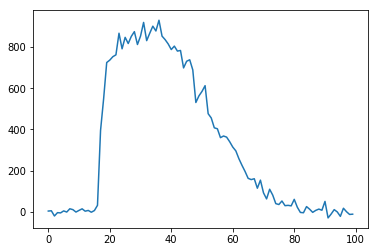

In [8]:
def hist_dp(df, col, lower, upper, epsilon):
    """ Returns a differentially private histogram
    using the laplace function
    
    Args:
    df -- dataframe 
    col -- column in the dataframe to count
    lower -- lower value to start from
    upper -- upper value to end at
    epsilon -- epsilon value for DP
    """
    
    vals = range(lower, upper)
    hist = [(df[df[col] == val]).shape[0] for val in vals]
    noisy_hist = [duet.laplace(v, ε=epsilon) for v in hist]
    return noisy_hist

epsilon = 0.1
with duet.EDOdometer() as odo:
    hist = hist_dp(adult_data, 'Age', 0, 100, epsilon)
    plt.plot(hist);

    #Using the histogram to get the ages in a certain range
    lower = 30
    upper = 42

    total = 0
    for i in range(lower, upper):
        total += hist[i]
    print('Ages between', lower, 'and', upper, 'using the histogram:', total)
    print('Privacy cost:', odo)

## Applications <a name="applications"></a>

### Sample Census calculation <a name="census"></a>

In [9]:
census_data = pd.read_csv('census_data.csv')

def hierarchical_query(df, cols, sum_col, epsilon):
    """ Returns a hierarchical query using parallel composition on each level
    
    Args:
    df -- dataframe 
    cols -- columns in the dataframe to count
    sum_col -- column in the dataframe to count 
    epsilon -- epsilon value for DP
    """
    sums = []
    for col in cols:
        sums.append(duet.laplace(df.groupby(col)[sum_col].sum(), epsilon=epsilon / len(cols)))
    return sums


epsilon = 0.1
with duet.EDOdometer() as odo:
    print('Query result:', hierarchical_query(census_data, ['CensusTract', 'State', 'County'], 'TotalPop', epsilon))
    print('Privacy cost:', odo)

Query result: [CensusTract
1001020100      1900.122596
1001020200      2157.669505
1001020300      2955.471758
1001020400      4336.304082
1001020500     10780.949138
                   ...     
72153750501     6271.641739
72153750502     2065.623715
72153750503     2285.597708
72153750601     5264.454045
72153750602     2753.182250
Name: TotalPop, Length: 74001, dtype: float64, State
Alabama                 4.830612e+06
Alaska                  7.333544e+05
Arizona                 6.641925e+06
Arkansas                2.958168e+06
California              3.842145e+07
Colorado                5.278863e+06
Connecticut             3.593115e+06
Delaware                9.264500e+05
District of Columbia    6.474774e+05
Florida                 1.964581e+07
Georgia                 1.000661e+07
Hawaii                  1.406283e+06
Idaho                   1.616600e+06
Illinois                1.287379e+07
Indiana                 6.568698e+06
Iowa                    3.093494e+06
Kansas              

### Auto generated statistics <a name="stats"></a>

In [10]:
import math

def auto_stats_svt(df, col, epsilon):
    """ Returns the mean and standard deviation of a column of a dataset
    automatically computes lower and upper clipping bounds
    
    Args:
    df -- dataframe 
    col -- column in the dataframe to get stats of
    epsilon -- epsilon value for DP
    """
    
    #helper functions to generate queries
    def lower(col, b):
        """ Helper function to generate a lower clipping bound"""
        return lambda df: df[col].clip(0, b).sum() - df[col].clip(0, b+1).sum()
    
    def upper(col, lower_b, b):
        """ Helper function to generate an upper clipping bound"""
        return lambda df: df[col].clip(lower_b, b+1).sum() - df[col].clip(lower_b, b).sum()
    
    #generate clipping bounds using SVT
    lower_queries = [lower(col, b) for b in bs]
    lower_b = bs[duet.above_threshold(lower_queries, df, 0, epsilon / 5)]
    upper_queries = [upper(col, lower_b, b) for b in reversed(bs)]
    upper_b = bs[duet.above_threshold(upper_queries, df, 0, epsilon / 5)]

    #mean
    noisy_sum = duet.laplace(df[col].clip(upper_b, lower_b).sum(), epsilon=epsilon / 5)
    noisy_count = duet.laplace(df.shape[0], epsilon=epsilon / 5)  
    mean = noisy_sum / noisy_count
    
    var = (df[col] - mean)
    temp = duet.laplace(var, epsilon=epsilon/5)
    var = (1 / noisy_count) * ((temp**2).sum())
    std_dev = math.sqrt(var)
    
    return mean, std_dev
    
bs = list(range(0, 200, 10))
epsilon = 10
with duet.EDOdometer() as odo:
    mean, std_dev = auto_stats_svt(adult_data, 'Age', epsilon)
    print('Mean:', mean, "Standard Deviation:", std_dev)
    print('Privacy cost:', odo)

Mean: 70.10566993195486 Standard Deviation: 34.351070043668
Privacy cost: ([DataSource(adult_with_pii.csv): (10.0, 0)])
